# A. Pelabelan Sentimen

In [3]:
# 0. INSTALASI DAN IMPORT PUSTAKA
# =========================================
# Pastikan library terinstal. Jalankan di terminal jika belum:
# pip install pandas torch transformers[sentencepiece] accelerate nltk tqdm

import pandas as pd
import re
import nltk
import time
import sys
import warnings
from transformers import pipeline
from tqdm import tqdm # Import tqdm untuk progress bar

# --- untuk menyembunyikan peringatan ---
warnings.filterwarnings("ignore", message="The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers.")
# ----------------------------------------------------

# Mengunduh komponen NLTK untuk memecah kalimat.
try:
    nltk.data.find('tokenizers/punkt')
    print("✅ Tokenizer 'punkt' dari NLTK sudah tersedia.")
except LookupError:
    print("Mengunduh tokenizer 'punkt' dari NLTK...")
    nltk.download('punkt', quiet=True)
    print("✅ Download 'punkt' selesai.")

try:
    nltk.data.find('tokenizers/punkt_tab')
    print("✅ Tokenizer 'punkt_tab' dari NLTK sudah tersedia.")
except LookupError:
    print("Mengunduh tokenizer 'punkt_tab' dari NLTK...")
    nltk.download('punkt_tab', quiet=True)
    print("✅ Download 'punkt_tab' selesai.")

print("✅ Semua libraries berhasil dimuat.")

# =================================================
# 1. MEMUAT DATASET DAN KAMUS ASPEK
# =================================================
try:
    df_kamus = pd.read_csv('/kaggle/input/kamus-aspek-v5/kamus_aspek_v5.csv')
    df_ulasan = pd.read_csv('/kaggle/input/tokopedia/tokopedia_reviews_date_cleaned.csv')
    print("\n📂 File kamus dan kumpulan data ulasan berhasil dimuat.")
except FileNotFoundError as e:
    print(f"\n--- ERROR: File tidak ditemukan ---")
    print(f"Detail: {e}")
    print("PASTIKAN file 'kamus_sinonim_v2_diperluas.csv' dan 'tokopedia_reviews_new.csv' berada di folder yang sama.")
    sys.exit()

# ===================================================
# 2. MEMBANGUN KAMUS ASPEK (METODE EFISIEN)
# ===================================================
kamus_aspek = {}
for _, row in df_kamus.fillna('').iterrows():
    aspek = row['Aspek']
    kategori = row['Kategori']
    kata_kunci = [row['Kata Kunci']] + [row[f'Sinonim {i}'] for i in range(1, 7)]
    sinonim_bersih = [kata.strip().lower() for kata in kata_kunci if kata]

    if aspek not in kamus_aspek:
        kamus_aspek[aspek] = {"kategori": kategori, "sinonim": []}

    for sinonim in sinonim_bersih:
        if sinonim not in kamus_aspek[aspek]['sinonim']:
            kamus_aspek[aspek]['sinonim'].append(sinonim)

print(f"\n📚 Kamus aspek berhasil disusun: {len(kamus_aspek)} aspek terdeteksi.")

# =================================================
# 3. MEMPROSES DATA ULASAN
# =================================================
# <-- PERUBAHAN 1: Menambahkan 'Review Rating Overall' saat memilih kolom
pros = df_ulasan[['Review Pros', 'Review Date', 'Review Rating Overall']].dropna().rename(columns={'Review Pros': 'review'})
pros['asal_kolom'] = 'pros'
cons = df_ulasan[['Review Cons', 'Review Date', 'Review Rating Overall']].dropna().rename(columns={'Review Cons': 'review'})
cons['asal_kolom'] = 'cons'

df_long = pd.concat([pros, cons], ignore_index=True)
df_long = df_long[df_long['review'].str.strip() != '']
df_long['review'] = df_long['review'].astype(str).str.lower()
print(f"🗃️ Total {len(df_long)} ulasan berhasil disiapkan untuk diproses.")

# ====================================================
# 4. INISIALISASI MODEL DAN FUNGSI HELPER
# ====================================================
print("\n🔄 Memuat model ABSA: 'yangheng/deberta-v3-base-absa-v1.1'...")
absa_pipeline = None
try:
    absa_pipeline = pipeline(
        "text-classification",
        model="yangheng/deberta-v3-base-absa-v1.1",
        tokenizer="yangheng/deberta-v3-base-absa-v1.1",
        top_k=None,
        device=0,
        truncation=True,
        max_length=512
    )
    print("⚡ Model berhasil dimuat")
except Exception as e:
    print(f"\n--- GAGAL MEMUAT MODEL ---\nDetail Error: {e}")
    print("Pastikan koneksi internet stabil dan coba jalankan lagi.")
    sys.exit()

def ekstrak_aspek_dalam_kalimat(kalimat):
    hasil = []
    pattern_template = r'\b{}\b'
    for aspek, detail in kamus_aspek.items():
        for sinonim in detail['sinonim']:
            if re.search(pattern_template.format(re.escape(sinonim)), kalimat):
                hasil.append({
                    "aspek": aspek,
                    "kategori": detail['kategori'],
                    "match": sinonim
                })
                break
    return hasil

# ==================================================
# 5. PROSES UTAMA - BATCH PROCESSING VERSION
# ==================================================
start_time = time.time()
print("\n🚀 Memulai Analisis Sentimen Berbasis Aspek (ABSA) dengan Batch Processing...")

# --- TAHAP 1: PENGUMPULAN DATA ---
print("   > Tahap 1: Mengumpulkan semua input untuk diproses...")
inputs_to_process = []
metadata_for_inputs = []

# Iterasi untuk mengumpulkan semua data yang akan diproses
for i, row in tqdm(df_long.iterrows(), total=len(df_long), desc="Mengumpulkan data", unit="ulasan"):
    review_text = row['review']
    kalimat_list = nltk.sent_tokenize(review_text)

    for kalimat in kalimat_list:
        kalimat = kalimat.strip()
        if not kalimat:
            continue

        aspek_ditemukan = ekstrak_aspek_dalam_kalimat(kalimat)
        if not aspek_ditemukan:
            continue

        for aspek_info in aspek_ditemukan:
            input_absa = f"{kalimat} [SEP] {aspek_info['aspek']}"
            inputs_to_process.append(input_absa)
            
            # <-- PERUBAHAN 2: Menambahkan 'Rating Overall' ke dalam metadata
            metadata_for_inputs.append({
                "Review ID": i,
                "Tanggal Review": row['Review Date'],
                "Rating Overall": row['Review Rating Overall'], # <-- BARIS INI DITAMBAHKAN
                "Tipe Review": row['asal_kolom'],
                "Kalimat": kalimat,
                "Aspek": aspek_info['aspek'],
                "Kategori": aspek_info['kategori'],
                "Kata yang Cocok": aspek_info['match'],
                "Ulasan Lengkap": review_text
            })

print(f"   > Selesai. Total {len(inputs_to_process)} pasangan kalimat-aspek akan diproses.")

# --- TAHAP 2: PEMROSESAN BATCH & PENGGABUNGAN HASIL ---
print("   > Tahap 2: Memproses semua input dalam satu batch di GPU...")
hasil_akhir = []
pipeline_results = []

if inputs_to_process:
    try:
        pipeline_results = absa_pipeline(inputs_to_process, batch_size=16, truncation=True)
    except Exception as e:
        print(f"\n--- GAGAL MEMPROSES BATCH ---\nDetail Error: {e}", file=sys.stderr)
        sys.exit()

    for metadata, result in tqdm(zip(metadata_for_inputs, pipeline_results), total=len(metadata_for_inputs), desc="Menggabungkan hasil", unit="item"):
        scores = {item['label'].lower(): item['score'] for item in result}
        skor_pos = scores.get('positive', 0.0)
        skor_neg = scores.get('negative', 0.0)
        skor_neu = scores.get('neutral', 0.0)

        if skor_pos > skor_neg and skor_pos > skor_neu:
            sentimen_utama = 'positif'
        elif skor_neg > skor_pos and skor_neg > skor_neu:
            sentimen_utama = 'negatif'
        else:
            sentimen_utama = 'netral'

        final_entry = metadata.copy()
        final_entry.update({
            "Sentimen Utama": sentimen_utama,
            "Skor Positif": round(skor_pos, 4),
            "Skor Negatif": round(skor_neg, 4),
            "Skor Netral": round(skor_neu, 4)
        })
        hasil_akhir.append(final_entry)

end_time = time.time()
print(f"\n✅ Proses ABSA dengan Batch Processing selesai dalam {end_time - start_time:.2f} detik.")


# ============================================
# 6. TAMPILKAN DAN SIMPAN HASIL AKHIR
# ============================================
if hasil_akhir:
    # <-- PERUBAHAN 3: Menambahkan 'Rating Overall' ke urutan kolom
    kolom_urut = [
        "Review ID", "Tanggal Review", "Rating Overall", "Tipe Review", "Kalimat", 
        "Aspek", "Kategori", "Kata yang Cocok", "Sentimen Utama", "Skor Positif", 
        "Skor Negatif", "Skor Netral", "Ulasan Lengkap"
    ]
    df_hasil_final = pd.DataFrame(hasil_akhir)
    
    # Memastikan semua kolom yang diinginkan ada sebelum mengurutkan
    kolom_final_tersedia = [kol for kol in kolom_urut if kol in df_hasil_final.columns]
    df_hasil_final = df_hasil_final[kolom_final_tersedia]

    print("\n--- CONTOH 15 HASIL AKHIR ANALISIS (METODE BATCH PROCESSING) ---")
    print(df_hasil_final.head(15).to_string())

    nama_file_hasil = "hasil_absa_batch_processing.csv"
    df_hasil_final.to_csv(nama_file_hasil, index=False, encoding='utf-8-sig')
    print(f"\n✅ Semua hasil ({len(df_hasil_final)} baris) telah disimpan ke file '{nama_file_hasil}'")
else:
    print("\n--- TIDAK ADA ASPEK YANG DITEMUKAN ATAU TERJADI ERROR SAAT BATCH PROCESSING ---")

2025-07-02 16:26:32.927384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751473593.136235      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751473593.198641      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Tokenizer 'punkt' dari NLTK sudah tersedia.
✅ Tokenizer 'punkt_tab' dari NLTK sudah tersedia.
✅ Semua libraries berhasil dimuat.

📂 File kamus dan kumpulan data ulasan berhasil dimuat.

📚 Kamus aspek berhasil disusun: 13 aspek terdeteksi.
🗃️ Total 3584 ulasan berhasil disiapkan untuk diproses.

🔄 Memuat model ABSA: 'yangheng/deberta-v3-base-absa-v1.1'...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


⚡ Model berhasil dimuat

🚀 Memulai Analisis Sentimen Berbasis Aspek (ABSA) dengan Batch Processing...
   > Tahap 1: Mengumpulkan semua input untuk diproses...


Mengumpulkan data: 100%|██████████| 3584/3584 [01:45<00:00, 34.03ulasan/s]


   > Selesai. Total 6148 pasangan kalimat-aspek akan diproses.
   > Tahap 2: Memproses semua input dalam satu batch di GPU...


Menggabungkan hasil: 100%|██████████| 6148/6148 [00:00<00:00, 214268.58item/s]


✅ Proses ABSA dengan Batch Processing selesai dalam 126.82 detik.

--- CONTOH 15 HASIL AKHIR ANALISIS (METODE BATCH PROCESSING) ---
    Review ID Tanggal Review  Rating Overall Tipe Review                                                               Kalimat                    Aspek   Kategori Kata yang Cocok Sentimen Utama  Skor Positif  Skor Negatif  Skor Netral                                                        Ulasan Lengkap
0           1     16-06-2025               5        pros       collaborative team, supporting each other with inspiring leader           Responsibility  Motivator          leader        positif        0.9932        0.0009       0.0059       collaborative team, supporting each other with inspiring leader
1           2     14-06-2025               4        pros                                good people culture growth opportunity              Advancement  Motivator     opportunity        positif        0.9947        0.0009       0.0045                       

# B. Analisis Hasil Sentimen

## 1. Data cleaning untuk agregasi 

In [13]:
# Asumsikan data awal bernama `df`
# Kolom penting: review_id, aspect, sentiment_label, period

import pandas as pd

# 0. konfigurasi
df = pd.read_csv("/kaggle/working/hasil_absa_batch_processing.csv")

# Step 1: Normalisasi kolom sentimen
df['Sentimen Utama'] = df['Sentimen Utama'].str.strip().str.capitalize()

# Step 2: Konversi tanggal
df['Tanggal Review'] = pd.to_datetime(df['Tanggal Review'], format="%d-%m-%Y")

# Step 3: Tentukan periode berdasarkan tanggal (cutoff: 1 Juli 2023)
cutoff_date = pd.Timestamp("2023-07-01")
df['period'] = df['Tanggal Review'].apply(lambda x: 'sebelum' if x < cutoff_date else 'sesudah')

# Step 4: Filter hanya sentimen polar
df_polar = df[df['Sentimen Utama'].isin(['Positif', 'Negatif'])].copy()
df_polar['sentiment_binary'] = df_polar['Sentimen Utama'].map({'Positif': 1, 'Negatif': 0})

# Step 5: Agregasi ke level review ID dan aspek
agg_df = (
    df_polar
    .groupby(['Review ID', 'period', 'Aspek'])['sentiment_binary']
    .mean()
    .reset_index()
)

# Step 6: Voting polaritas final
agg_df['sentiment_final'] = agg_df['sentiment_binary'].apply(
    lambda x: 'Positif' if x > 0.5 else ('Negatif' if x < 0.5 else 'Netral')
)

# Step 7: Ringkasan jumlah review Positif/Negatif per aspek per periode
summary = (
    agg_df[agg_df['sentiment_final'] != 'Netral']
    .groupby(['Aspek', 'period', 'sentiment_final'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# 5. simpan
OUTPUT = "hasil_aggregasi.csv"
summary.to_csv(OUTPUT, index=False)
print(f"✓ Berhasil: {OUTPUT} (rows = {len(summary)})")

✓ Berhasil: hasil_aggregasi.csv (rows = 26)


## 2. Kalkulasi  Δ Net-Score dan z-test

In [18]:
from statsmodels.stats.proportion import proportions_ztest

# Step 1: Hitung total review (polar) per aspek & periode
summary['Total'] = summary['Negatif'] + summary['Positif']

# Step 2: Pivot tabel supaya mudah dihitung selisihnya
pivot = summary.pivot(index='Aspek', columns='period', values=['Positif', 'Negatif', 'Total'])
pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.dropna()  # pastikan aspek muncul di dua periode

# Step 3: Hitung Net-Score
pivot['NetScore_sebelum'] = (pivot['Positif_sebelum'] - pivot['Negatif_sebelum']) / pivot['Total_sebelum']
pivot['NetScore_sesudah'] = (pivot['Positif_sesudah'] - pivot['Negatif_sesudah']) / pivot['Total_sesudah']
pivot['Delta_NetScore'] = pivot['NetScore_sesudah'] - pivot['NetScore_sebelum']

# Step 4: Hitung z-test untuk proporsi positif antar periode
p_values = []
for aspek in pivot.index:
    count = [pivot.loc[aspek, 'Positif_sebelum'], pivot.loc[aspek, 'Positif_sesudah']]
    nobs = [pivot.loc[aspek, 'Total_sebelum'], pivot.loc[aspek, 'Total_sesudah']]
    stat, pval = proportions_ztest(count, nobs)
    p_values.append(pval)

pivot['p_value'] = p_values

# Finalize output
final_df = pivot[['NetScore_sebelum', 'NetScore_sesudah', 'Delta_NetScore', 'p_value']]
final_df = final_df.reset_index().sort_values(by='Delta_NetScore', ascending=False)

# 5. simpan
OUTPUT = "hasil_kalkulasi.csv"
final_df.to_csv(OUTPUT, index=False)
print(f"✓ Berhasil: {OUTPUT} (rows = {len(final_df)})")

✓ Berhasil: hasil_kalkulasi.csv (rows = 13)


## 3. Visualisasi Perubahan Sentimen Positif per Aspek (Δ dalam pp)

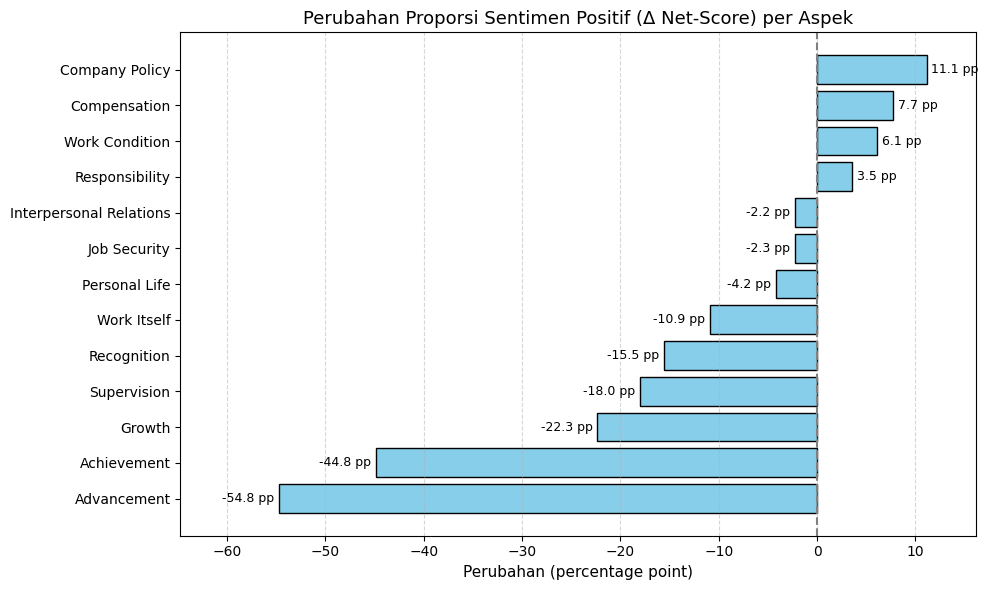

In [22]:
import matplotlib.pyplot as plt

# Siapkan data
df_plot = final_df.copy()
df_plot['Delta_pp'] = df_plot['Delta_NetScore'] * 100
df_plot = df_plot.sort_values(by='Delta_pp', ascending=True)

# Buat plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df_plot['Aspek'], df_plot['Delta_pp'], color='skyblue', edgecolor='black')

# Tambahkan garis nol
plt.axvline(0, color='gray', linestyle='--')

# Tambahkan label nilai di ujung batang
for bar in bars:
    width = bar.get_width()
    x_pos = width if width > 0 else width
    ha = 'left' if width > 0 else 'right'
    padding = 0.5
    plt.text(
        x_pos + (padding if width > 0 else -padding),
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f} pp",
        va='center',
        ha=ha,
        fontsize=9,
        color='black'
    )

# Judul dan label sumbu X saja
plt.title("Perubahan Proporsi Sentimen Positif (Δ Net-Score) per Aspek", fontsize=13)
plt.xlabel("Perubahan (percentage point)", fontsize=11)
plt.ylabel("")  # ← Menghilangkan label sumbu Y

# Margin & grid
plt.xlim(df_plot['Delta_pp'].min() - 10, df_plot['Delta_pp'].max() + 5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Tabel 5.3 Δ Proporsi Positif per Aspek

In [24]:
# Ambil data dari hasil z-test sebelumnya (pivot)
tabel_53 = pivot[['Positif_sebelum', 'Total_sebelum', 'Positif_sesudah', 'Total_sesudah']].copy()

# Hitung proporsi positif dan delta
tabel_53['Proporsi_Pos_Sebelum'] = tabel_53['Positif_sebelum'] / tabel_53['Total_sebelum']
tabel_53['Proporsi_Pos_Sesudah'] = tabel_53['Positif_sesudah'] / tabel_53['Total_sesudah']
tabel_53['Delta_Pos_pp'] = (tabel_53['Proporsi_Pos_Sesudah'] - tabel_53['Proporsi_Pos_Sebelum']) * 100

# Rapikan format
tabel_53 = tabel_53[['Proporsi_Pos_Sebelum', 'Proporsi_Pos_Sesudah', 'Delta_Pos_pp']]
tabel_53 = tabel_53.reset_index().sort_values(by='Delta_Pos_pp', ascending=False)

# Format 2 desimal
tabel_53 = tabel_53.round({'Proporsi_Pos_Sebelum': 2, 'Proporsi_Pos_Sesudah': 2, 'Delta_Pos_pp': 1})

# 5. simpan
OUTPUT = "tabel_5.3.csv"
tabel_53.to_csv(OUTPUT, index=False)
print(f"✓ Berhasil: {OUTPUT} (rows = {len(tabel_53)})")

✓ Berhasil: tabel_5.3.csv (rows = 13)


## Tabel 5.4 - Uji Signifikansi Perubahan Proporsi Positif




In [3]:
# Re-import all needed libraries (in case they are reset)
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Load the original data that contains Positif/Total per periode per aspek
summary_path = "/kaggle/input/batch-absa/hasil_absa_batch_processing.csv"
df = pd.read_csv(summary_path)

# Preprocess: clean column, datetime, and polarity
df['Sentimen Utama'] = df['Sentimen Utama'].str.strip().str.capitalize()
df['Tanggal Review'] = pd.to_datetime(df['Tanggal Review'], format="%d-%m-%Y")
df['period'] = df['Tanggal Review'].apply(lambda x: 'sebelum' if x < pd.Timestamp("2023-07-01") else 'sesudah')
df_polar = df[df['Sentimen Utama'].isin(['Positif', 'Negatif'])].copy()
df_polar['sentiment_binary'] = df_polar['Sentimen Utama'].map({'Positif': 1, 'Negatif': 0})

# Agregasi ulang
agg_df = (
    df_polar
    .groupby(['Review ID', 'period', 'Aspek'])['sentiment_binary']
    .mean()
    .reset_index()
)

agg_df['sentiment_final'] = agg_df['sentiment_binary'].apply(
    lambda x: 'Positif' if x > 0.5 else ('Negatif' if x < 0.5 else 'Netral')
)

summary = (
    agg_df[agg_df['sentiment_final'] != 'Netral']
    .groupby(['Aspek', 'period', 'sentiment_final'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Buat pivot tabel
pivot = summary.pivot(index='Aspek', columns='period', values=['Positif', 'Negatif'])
pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.dropna()  # hanya aspek yang tersedia di kedua periode

# Hitung z dan p
p_values = []
z_scores = []
for aspek in pivot.index:
    count = [pivot.loc[aspek, 'Positif_sebelum'], pivot.loc[aspek, 'Positif_sesudah']]
    nobs = [pivot.loc[aspek, 'Positif_sebelum'] + pivot.loc[aspek, 'Negatif_sebelum'],
            pivot.loc[aspek, 'Positif_sesudah'] + pivot.loc[aspek, 'Negatif_sesudah']]
    z, p = proportions_ztest(count, nobs)
    z_scores.append(round(z, 2))
    p_values.append(round(p, 3))

# Hitung delta positif (pp)
delta_pp = ((pivot['Positif_sesudah'] / (pivot['Positif_sesudah'] + pivot['Negatif_sesudah'])) -
            (pivot['Positif_sebelum'] / (pivot['Positif_sebelum'] + pivot['Negatif_sebelum']))) * 100

# Final table
tabel_54 = pd.DataFrame({
    'Aspek': pivot.index,
    'Δ (pp)': delta_pp.round(1),
    'z': z_scores,
    'p': p_values,
    'Sig. ★': ['★' if p < 0.05 else '' for p in p_values]
}).sort_values(by='p')

# 5. simpan
OUTPUT = "tabel_5.4.csv"
tabel_54.to_csv(OUTPUT, index=False)
print(f"✓ Berhasil: {OUTPUT} (rows = {len(tabel_54)})")

✓ Berhasil: tabel_5.4.csv (rows = 13)


## Visualisasi Priority Grid

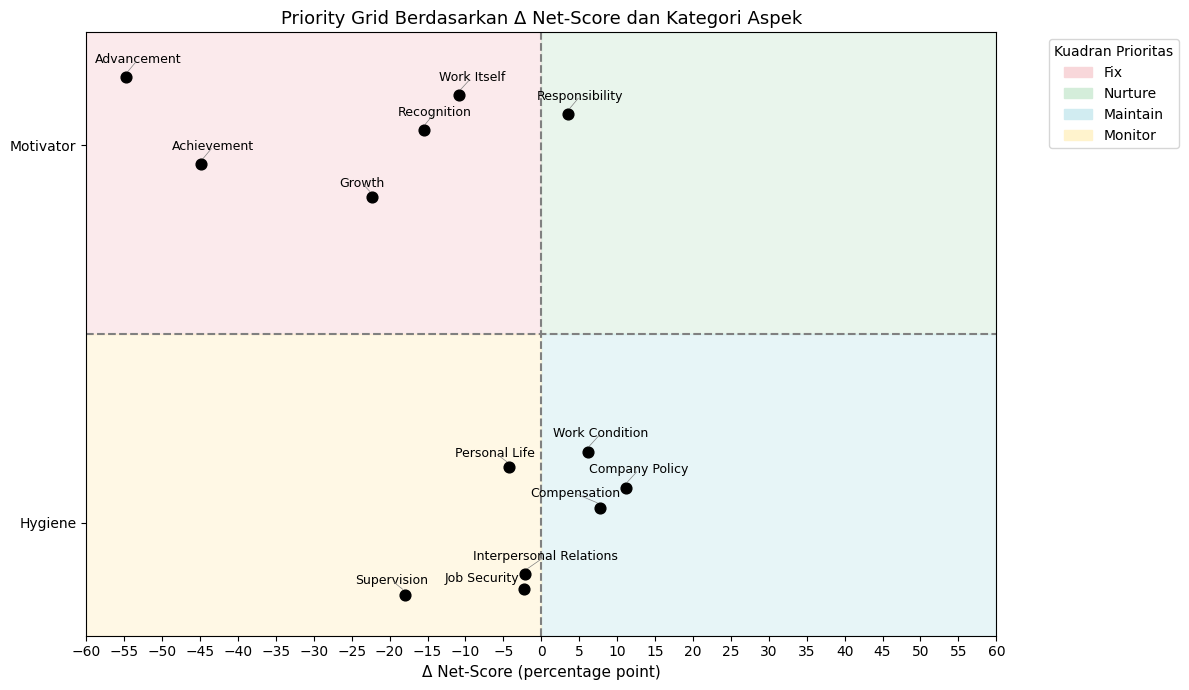

In [43]:
# STEP 1: Import library
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from adjustText import adjust_text
import numpy as np

# STEP 2: Baca data ABSA hasil labeling
df = pd.read_csv("/kaggle/input/batch-absa/hasil_absa_batch_processing.csv")

# --- PREPROCESSING ---
df['Sentimen Utama'] = df['Sentimen Utama'].str.strip().str.capitalize()
df['Tanggal Review'] = pd.to_datetime(df['Tanggal Review'], format="%d-%m-%Y")
df['period'] = df['Tanggal Review'].apply(lambda x: 'sebelum' if x < pd.Timestamp("2023-07-01") else 'sesudah')
df_polar = df[df['Sentimen Utama'].isin(['Positif', 'Negatif'])].copy()
df_polar['sentiment_binary'] = df_polar['Sentimen Utama'].map({'Positif': 1, 'Negatif': 0})

agg_df = (
    df_polar
    .groupby(['Review ID', 'period', 'Aspek'])['sentiment_binary']
    .mean()
    .reset_index()
)
agg_df['sentiment_final'] = agg_df['sentiment_binary'].apply(
    lambda x: 'Positif' if x > 0.5 else ('Negatif' if x < 0.5 else 'Netral')
)

summary = (
    agg_df[agg_df['sentiment_final'] != 'Netral']
    .groupby(['Aspek', 'period', 'sentiment_final'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

pivot = summary.pivot(index='Aspek', columns='period', values=['Positif', 'Negatif'])
pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.dropna()

# --- NET SCORE CALCULATION ---
pivot['Total_sebelum'] = pivot['Positif_sebelum'] + pivot['Negatif_sebelum']
pivot['Total_sesudah'] = pivot['Positif_sesudah'] + pivot['Negatif_sesudah']
pivot['NetScore_sebelum'] = (pivot['Positif_sebelum'] - pivot['Negatif_sebelum']) / pivot['Total_sebelum']
pivot['NetScore_sesudah'] = (pivot['Positif_sesudah'] - pivot['Negatif_sesudah']) / pivot['Total_sesudah']
pivot['Delta_NetScore'] = pivot['NetScore_sesudah'] - pivot['NetScore_sebelum']

# --- PREPARE GRID_DF ---
motivator = [
    'Achievement', 'Recognition', 'Work Itself', 'Responsibility', 'Growth', 'Advancement'
]
hygiene = [
    'Compensation', 'Supervision', 'Work Condition', 'Interpersonal Relations',
    'Company Policy', 'Job Security', 'Personal Life'
]

grid_df = pivot[['NetScore_sebelum', 'NetScore_sesudah', 'Delta_NetScore']].copy()
grid_df['Kategori'] = grid_df.index.map(
    lambda x: 'Motivator' if x in motivator else ('Hygiene' if x in hygiene else 'Lain')
)
grid_df['X'] = grid_df['Delta_NetScore'] * 100
grid_df['Y_num'] = grid_df['Kategori'].map({'Hygiene': 0, 'Motivator': 1})

# --- TAMBAHKAN JITTER UNTUK SEBAR Y ---
np.random.seed(42)
jitter_strength = 0.20
grid_df['Y_jittered'] = grid_df['Y_num'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(grid_df))

# --- PLOT PRIORITY GRID ---
plt.figure(figsize=(12, 7))
plt.gca().add_patch(patches.Rectangle((-60, 0.5), 60, 0.8, color='#f8d7da', alpha=0.5))
plt.gca().add_patch(patches.Rectangle((0, 0.5), 60, 0.8, color='#d4edda', alpha=0.5))
plt.gca().add_patch(patches.Rectangle((0, -0.3), 60, 0.8, color='#d1ecf1', alpha=0.5))
plt.gca().add_patch(patches.Rectangle((-60, -0.3), 60, 0.8, color='#fff3cd', alpha=0.5))

plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0.5, color='gray', linestyle='--')

scatter = plt.scatter(grid_df['X'], grid_df['Y_jittered'], color='black', s=60, zorder=5)

# --- LABEL DENGAN ADJUSTTEXT ---
texts = []
# Tambahkan sedikit offset vertikal awal
label_offset = 0.01  # atau 0.06 kalau mau lebih tinggi
for i, row in grid_df.iterrows():
    texts.append(plt.text(row['X'], row['Y_jittered'] + label_offset, i, fontsize=9, ha='center', va='bottom'))


adjust_text(
    texts,
    x=grid_df['X'].tolist(),
    y=grid_df['Y_jittered'].tolist(),
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    only_move={'points': 'y', 'text': 'xy'},
    expand_text=(1.6, 1.8),      # jarak antar label lebih besar
    expand_points=(1.6, 2.0),    # jarak label ke titik lebih besar
    force_text=0.9,              # dorong lebih jauh
    force_points=0.9
)

# --- FORMAT DAN LEGEND ---
plt.yticks([0, 1], ['Hygiene', 'Motivator'])
plt.xticks(np.arange(-60, 61, 5))
plt.xlabel("Δ Net-Score (percentage point)", fontsize=11)
plt.title("Priority Grid Berdasarkan Δ Net-Score dan Kategori Aspek", fontsize=13)
plt.xlim(-60, 60)
plt.ylim(-0.3, 1.3)

legend_labels = ['Fix', 'Nurture', 'Maintain', 'Monitor']
legend_colors = ['#f8d7da', '#d4edda', '#d1ecf1', '#fff3cd']
patches_list = [patches.Patch(color=c, label=l) for c, l in zip(legend_colors, legend_labels)]
plt.legend(handles=patches_list, title="Kuadran Prioritas", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()